# Investigating which areas show significant second level effects at which times

In [1]:
%matplotlib notebook
import numpy as np
import helpers
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import source_visualisations as sv
import mne

## Data preparation
Which data?

In [2]:
# baseline [-0.3, 0], trialregs_dot=5
# basefile = 'source_HCPMMP1_allsubs_201703301614.h5'

# baseline None, trialregs_dot=5
#basefile = 'source_HCPMMP1_allsubs_201706091054.h5'

# baseline (-0.3, 0), trialregs_dot=5, GLM in source space
#basefile = 'source_sequential_201706141650.h5'

# baseline (-0.3, 0), trialregs_dot=5, GLM in source space, move_dist, sum_dot_y
#basefile = 'source_sequential_201706191442.h5'

# baseline (-0.3, 0), trialregs_dot=5, GLM in source space, move_dist, 
# sum_dot_y, constregs=0 for 1st dot
#basefile = 'source_sequential_201706201654.h5'

# baseline (-0.3, 0), only first 3 dots, trialregs_dot=3, GLM in source space, move_dist, 
# sum_dot_y, constregs=0 for 1st dot
basefile = 'source_sequential_201706261151.h5'

choose measure and identify threshold

In [3]:
# e.g.: mu_p_large, mu_testval, mu_t, mu_mean
measure = 'mu_testval'

# which regressors should define the empirical value distribution?
# set regressors = None for all
regressors = ['dot_x', 'dot_y', 'abs_dot_x', 'abs_dot_y']

# do not use these regressors to define empirical value distribution
exclude = 'trialregs'

# the empiric error threshold for a single time point and area
# (the selected threshold will be the quantile 1-alpha of the 
# empirical distribution of measure values)
alpha = 0.05

threshold, measure_cdf = sv.find_slabs_threshold(
    basefile, measure, quantile=1-alpha, regressors=regressors, 
    exclude=exclude, verbose=1, return_cdf=True)

print('\nthreshold = {:.4f}'.format(threshold))

excluding:
intercept
entropy
response
trial_time

adding abs_dot_x
adding abs_dot_y
adding dot_x
adding dot_y
N = 101360

threshold = 0.0002


what are large values for the possible measures (used for setting y-lim in plotting)

In [4]:
ylims = {'mu_p_large': 1, 'mu_t': 8, 'mu_z': 8, 'mu_testval': 0.02, 'mu_mean': 0.8}
logy = {'mu_p_large': False, 'mu_t': False, 'mu_z': False, 'mu_testval': True, 'mu_mean': False}

## Load data for all selected regressors and identify significant clusters in time
The idea is that you identify sequences of high measure values that cannot happen by chance. This is all based on the empirical measure distribution used above. This distribution defines the probability with which I would get a particular measure value, if I were to draw one randomly across locations, time points and regressors. So it is a permutation distribution. I then use the cumulative density function of this distribution to first select a cluster threshold, i.e., a measure value which has to be exceeded in order to form a sequence cluster. Then I identify clusters, i.e., sequences of measure values within an area that exceed the threshold. The p-value of the found cluster is the product of 1-cdf(value) for the measure values in the sequence.

In [5]:
clusters = []
for r_name in regressors:
    srcfile = basefile[:-3] + '_slabs_%s.h5' % r_name
    file = 'mne_subjects/fsaverage/bem/' + srcfile
    src_df = pd.read_hdf(file, 'second_level_src')
    clusters.append(sv.get_time_clusters(src_df[measure], threshold, measure_cdf))

clusters = pd.concat(clusters, keys=regressors, names=['regressor', 'cluster'])

now FDR-correct the found clusters

In [6]:
cluster_alpha = 0.001
reject, pval = mne.stats.fdr_correction(10**clusters.log10p, cluster_alpha)
clusters['pval_corrected'] = pval
clusters = clusters[reject]

# add region of area for information
def get_region(area):
    if area.startswith('??'):
        section = 'whole hemisphere'
    else:
        section = sv.Glasser_areas[sv.Glasser_areas['area name'] == area[2:-7]]['main section']
        section = sv.Glasser_sections.loc[section].name.values[0]
    
    return section
clusters['region'] = clusters.label.apply(get_region)

clusters

label  start_t  end_t     log10p  pval_corrected  \
regressor cluster                                                              
dot_x     13           L_1_ROI-lh      290    340 -10.701343    7.317550e-10   
          14           L_1_ROI-lh      400    430  -5.705703    2.493033e-05   
          15           L_1_ROI-lh      470    490  -4.653370    1.979021e-04   
          31        L_24dd_ROI-lh      440    470  -6.208248    9.218503e-06   
          34        L_24dv_ROI-lh      300    320  -7.812718    3.433755e-07   
          36        L_24dv_ROI-lh      430    500 -17.928857    8.984363e-17   
          40        L_24dv_ROI-lh      680    690  -4.097225    6.157116e-04   
          44           L_2_ROI-lh      160    180  -7.075772    1.591740e-06   
          46           L_2_ROI-lh      390    510 -25.756357    2.283280e-24   
          54         L_31a_ROI-lh      400    440  -8.951201    3.123984e-08   
          56         L_31a_ROI-lh      590    610  -4.988990    1.048133e-04   
          60        L_31pd_ROI-lh      320    450 -35.022218    2.971048e-33   
          61        L_31pd_ROI-lh      470    480  -4.401866    3.296661e-04   
          65        L_31pv_ROI-lh      300    490 -57.952438    3.488913e-55   
          68        L_33pr_ROI-lh      300    320  -5.378201    4.777230e-05   
          70        L_33pr_ROI-lh      400    500 -27.882844    2.047639e-26   
          72        L_33pr_ROI-lh      570    590  -4.457481    2.931597e-04   
          75          L_3a_ROI-lh      290    410 -24.690274    2.552195e-23   
          76          L_3a_ROI-lh      430    460  -8.093922    1.967867e-07   
          77          L_3a_ROI-lh      480    500  -6.649890    3.704895e-06   
          81          L_3b_ROI-lh      300    360 -14.724545    1.052918e-13   
          82          L_3b_ROI-lh      400    530 -29.563089    5.030258e-28   
          96           L_4_ROI-lh      300    340 -10.731596    6.983330e-10   
          97           L_4_ROI-lh      390    490 -23.498643    3.420480e-22   
          98           L_4_ROI-lh      510    540  -6.240748    8.719916e-06   
          105         L_5L_ROI-lh       30     50  -4.856020    1.340369e-04   
          106         L_5L_ROI-lh       70     90  -6.047274    1.263284e-05   
          108         L_5L_ROI-lh      240    300 -15.405042    2.278725e-14   
          109         L_5L_ROI-lh      320    340  -4.978670    1.069841e-04   
          114         L_5m_ROI-lh      410    430  -4.853919    1.342739e-04   
...                           ...      ...    ...        ...             ...   
abs_dot_y 184        L_PIT_ROI-lh      160    180  -5.190709    7.072518e-05   
          189         L_PI_ROI-lh      290    310  -4.897698    1.240622e-04   
          194       L_POS2_ROI-lh      660    680  -5.323668    5.357726e-05   
          209       L_ProS_ROI-lh      100    110  -4.106197    6.076107e-04   
          211       L_ProS_ROI-lh      530    550  -4.568400    2.353061e-04   
          215       L_STGa_ROI-lh        0     30  -7.971214    2.493499e-07   
          249         L_V4_ROI-lh      530    550  -5.898362    1.674380e-05   
          251         L_V4_ROI-lh      640    660  -6.862171    2.426517e-06   
          284       L_VMV2_ROI-lh      100    130  -6.148821    1.037436e-05   
          299      L_a32pr_ROI-lh      150    190  -7.793345    3.494785e-07   
          302      L_d23ab_ROI-lh      180    230 -12.117982    3.404456e-11   
          303      L_d23ab_ROI-lh      270    300  -5.631292    2.911806e-05   
          326        R_23d_ROI-rh      190    220  -7.536650    5.979078e-07   
          327        R_23d_ROI-rh      250    270  -5.592943    3.143048e-05   
          337       R_31pv_ROI-rh      210    230  -4.527390    2.550565e-04   
          383        R_8Av_ROI-rh      190    200  -4.041436    6.882436e-04   
          399        R_DVT_ROI-rh      110    120  -4.470953    2.865155e-04   
          445         R_Ig_R

## Find all clusters of a given area or region

In [7]:
area = 'v23ab'
clusters[clusters.label.apply(lambda s: s.find(area) >= 0)]

label  start_t  end_t     log10p  pval_corrected  \
regressor cluster                                                              
dot_x     499      L_v23ab_ROI-lh      110    130  -7.548178    5.874669e-07   
          500      L_v23ab_ROI-lh      160    190  -7.547167    5.874669e-07   
          502      L_v23ab_ROI-lh      310    490 -55.903250    1.953653e-53   
          1123     R_v23ab_ROI-rh      100    120  -8.182910    1.628725e-07   
          1124     R_v23ab_ROI-rh      160    190  -6.564309    4.395587e-06   
          1125     R_v23ab_ROI-rh      300    360 -22.996574    1.016699e-21   
          1126     R_v23ab_ROI-rh      380    510 -34.555796    7.246874e-33   
          1127     R_v23ab_ROI-rh      530    560  -6.407805    6.113539e-06   
dot_y     736      R_v23ab_ROI-rh      650    670  -4.626104    2.085910e-04   
abs_dot_y 591      R_v23ab_ROI-rh      200    220  -5.233827    6.501658e-05   

                                       region  
regressor cluster                              
dot_x     499      posterior cingulate cortex  
          500      posterior cingulate cortex  
          502      posterior cingulate cortex  
          1123     posterior cingulate cortex  
          1124     posterior cingulate cortex  
          1125     posterior cingulate cortex  
          1126     posterior cingulate cortex  
          1127     posterior cingulate cortex  
dot_y     736      posterior cingulate cortex  
abs_dot_y 591      posterior cingulate cortex

In [8]:
region = 'dorsolat'
clusters[clusters.region.apply(lambda s: s.find(region) >= 0)]

label  start_t  end_t     log10p  pval_corrected  \
regressor cluster                                                             
dot_x     362       L_SFL_ROI-lh      300    320  -4.264149    4.386791e-04   
          365       L_SFL_ROI-lh      450    480  -6.834792    2.551618e-06   
          1077     R_i6-8_ROI-rh      410    460 -12.918238    5.991685e-12   
          1079     R_i6-8_ROI-rh      530    550  -5.084638    8.752715e-05   
          1121     R_s6-8_ROI-rh      450    480  -7.962381    2.525882e-07   
          1122     R_s6-8_ROI-rh      560    580  -4.828381    1.411077e-04   
dot_y     448       R_8Av_ROI-rh      140    180  -7.573649    5.639196e-07   
abs_dot_x 354       R_8Av_ROI-rh      310    350  -9.939485    3.709788e-09   
          356        R_8C_ROI-rh      330    350  -5.878269    1.738929e-05   
abs_dot_y 86         L_9p_ROI-lh      140    160  -5.679057    2.640091e-05   
          383       R_8Av_ROI-rh      190    200  -4.041436    6.882436e-04   

                                           region  
regressor cluster                                  
dot_x     362      dorsolateral prefrontal cortex  
          365      dorsolateral prefrontal cortex  
          1077     dorsolateral prefrontal cortex  
          1079     dorsolateral prefrontal cortex  
          1121     dorsolateral prefrontal cortex  
          1122     dorsolateral prefrontal cortex  
dot_y     448      dorsolateral prefrontal cortex  
abs_dot_x 354      dorsolateral prefrontal cortex  
          356      dorsolateral prefrontal cortex  
abs_dot_y 86       dorsolateral prefrontal cortex  
          383      dorsolateral prefrontal cortex

## Investigate individual regressors

In [9]:
r_name = 'dot_x'
r_clusters = clusters.xs(r_name, level='regressor')

srcfile = basefile[:-3] + '_slabs_%s.h5' % r_name
file = 'mne_subjects/fsaverage/bem/' + srcfile
src_df = pd.read_hdf(file, 'second_level_src')

### Check the times at which we see significant clusters

<IPython.core.display.Javascript object>


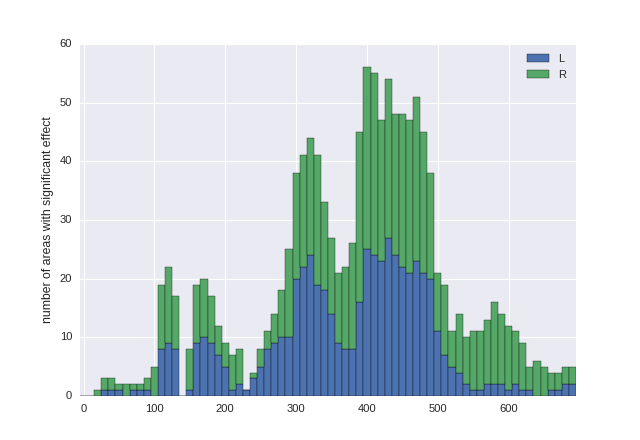

In [10]:
times = src_df[measure].index.levels[1]
sigareas = r_clusters.label.unique()
significant = pd.DataFrame(np.zeros((sigareas.size, times.size), bool), 
                           index=sigareas, columns=times)
for row in r_clusters.itertuples():
    significant.loc[row.label, slice(row.start_t, row.end_t)] = True
    
fig, ax = plt.subplots()
left = significant.columns - 5
colors = plt.rcParams['axes.prop_cycle']._left

# plot left hemi 
numlh = significant[significant.index.map(lambda l: l[0]) == 'L'].sum()
ax.bar(left, height=numlh, width=10, bottom=0, color=colors[0]['color'])
# plot right hemi
ax.bar(left, 
       height=significant[significant.index.map(lambda l: l[0]) == 'R'].sum(), 
       width=10, bottom=numlh, color=colors[1]['color'])
ax.set_ylabel('number of areas with significant effect');
ax.legend(['L', 'R']);
ax.set_xlim(left[0], left[-1]+10);

### Identify areas

In [11]:
def get_areas(times):
    if type(times) is not list:
        times = [times]
    
    return significant[np.all(significant[times], axis=1)].index

def active_areas(times, times2=None):
    """Returns areas that are reliably activated at all time points in times.
       If times2 is provided, intersection and set differences of areas 
       associated with times and times2 are indicated."""
    
    print(r_name)
    
    areas = get_areas(times)
    
    if times2 is None:
        areas2 = pd.Index([])
    else:
        areas2 = get_areas(times2)
    
    areas = pd.concat([pd.Series(areas.difference(areas2)), 
                       pd.Series(areas.intersection(areas2)), 
                       pd.Series(areas2.difference(areas))],
                      keys=['only 1', 'intersect', 'only 2'])
    areas = pd.DataFrame(areas, columns=['area'])
    
    areas['region'] = areas.area.apply(get_region)
    
    return areas

In [12]:
active_areas(400, 590)

dot_x


area                                           region
only 1    0       L_1_ROI-lh                   somatosensory and motor cortex
          1       L_2_ROI-lh                   somatosensory and motor cortex
          2    L_31pd_ROI-lh                       posterior cingulate cortex
          3    L_31pv_ROI-lh                       posterior cingulate cortex
          4      L_3a_ROI-lh                   somatosensory and motor cortex
          5      L_3b_ROI-lh                   somatosensory and motor cortex
          6       L_4_ROI-lh                   somatosensory and motor cortex
          7      L_6d_ROI-lh                                  premotor cortex
          8      L_7m_ROI-lh                       posterior cingulate cortex
          9     L_AIP_ROI-lh                         superior parietal cortex
          10    L_DVT_ROI-lh                       posterior cingulate cortex
          11    L_FEF_ROI-lh                                  premotor cortex
          12   L_IFJa_ROI-lh                          inferior frontal cortex
          13    L_IP0_ROI-lh                         inferior parietal cortex
          14   L_IPS1_ROI-lh                      dorsal stream visual cortex
          15   L_LIPd_ROI-lh                         superior parietal cortex
          16    L_PCV_ROI-lh                       posterior cingulate cortex
          17     L_PI_ROI-lh             insular and frontal opercular cortex
          18     L_RI_ROI-lh                            early auditory cortex
          19     L_TF_ROI-lh                          lateral temporal cortex
          20  L_d23ab_ROI-lh                       posterior cingulate cortex
          21    L_p32_ROI-lh  anterior cingulate and medial prefrontal cortex
          22  L_v23ab_ROI-lh                       posterior cingulate cortex
          23      R_1_ROI-rh                   somatosensory and motor cortex
          24    R_31a_ROI-rh                       posterior cingulate cortex
          25   R_31pd_ROI-rh                       posterior cingulate cortex
          26   R_31pv_ROI-rh                       posterior cingulate cortex
          27   R_33pr_ROI-rh  anterior cingulate and medial prefrontal cortex
          28     R_3b_ROI-rh                   somatosensory and motor cortex
          29      R_4_ROI-rh                   somatosensory and motor cortex
...                      ...                                              ...
          31    R_5mv_ROI-rh     paracentral lobular and mid cingulate cortex
          32    R_7Pm_ROI-rh                         superior parietal cortex
          33     R_7m_ROI-rh                       posterior cingulate cortex
          34    R_DVT_ROI-rh                       posterior cingulate cortex
          35    R_IP0_ROI-rh                         inferior parietal cortex
          36  R_OP2-3_ROI-rh                       posterior opercular cortex
          37    R_PCV_ROI-rh                       posterior cingulate cortex
          38    R_PEF_ROI-rh                                  premotor cortex
          39    R_PFt_ROI-rh                         inferior parietal cortex
          40    R_RSC_ROI-rh                       posterior cingulate cortex
          41   R_SCEF_ROI-rh     paracentral lobular and mid cingulate cortex
          42  R_TPOJ2_ROI-rh               temporo-parieto-occipital junction
          43     R_V6_ROI-rh                      dorsal stream visual cortex
          44     R_V7_ROI-rh                      dorsal stream visual cortex
          45  R_d23ab_ROI-rh                       posterior cingulate cortex
          46  R_v23ab_ROI-rh                       posterior cingulate cortex
intersect 0     L_31a_ROI-lh                       posterior cingulate cortex
          1    L_33pr_ROI-lh  anterior cingulate and medial prefrontal cortex
          2    R_24dv_ROI-rh     paracentral lobular and mid cingulate cortex
          3      R_6a_ROI-rh                  

In [13]:
active_areas(580, 680)

dot_x


area                                           region
only 1    0    L_33pr_ROI-lh  anterior cingulate and medial prefrontal cortex
          1     L_FEF_ROI-lh                                  premotor cortex
          2      R_25_ROI-rh  anterior cingulate and medial prefrontal cortex
          3     R_47s_ROI-rh                 orbital and polar frontal cortex
          4     R_FEF_ROI-rh                                  premotor cortex
          5     R_OFC_ROI-rh                 orbital and polar frontal cortex
          6    R_STGa_ROI-rh                      auditory association cortex
          7      R_V7_ROI-rh                      dorsal stream visual cortex
          8   R_a24pr_ROI-rh  anterior cingulate and medial prefrontal cortex
          9   R_p24pr_ROI-rh  anterior cingulate and medial prefrontal cortex
          10  R_p32pr_ROI-rh  anterior cingulate and medial prefrontal cortex
          11    R_s32_ROI-rh  anterior cingulate and medial prefrontal cortex
          12   R_s6-8_ROI-rh                   dorsolateral prefrontal cortex
intersect 0    R_24dv_ROI-rh     paracentral lobular and mid cingulate cortex
          1      R_6a_ROI-rh                                  premotor cortex
          2      R_6d_ROI-rh                                  premotor cortex
only 2    0    L_24dv_ROI-lh     paracentral lobular and mid cingulate cortex
          1     L_7Pm_ROI-lh                         superior parietal cortex

In [14]:
active_areas(170, 320)

dot_x


area                                           region
only 1    0       L_2_ROI-lh                   somatosensory and motor cortex
          1     L_7Am_ROI-lh                         superior parietal cortex
          2     L_AIP_ROI-lh                         superior parietal cortex
          3     L_DVT_ROI-lh                       posterior cingulate cortex
          4     L_IP0_ROI-lh                         inferior parietal cortex
          5     L_IP1_ROI-lh                         inferior parietal cortex
          6    L_IPS1_ROI-lh                      dorsal stream visual cortex
          7    L_POS2_ROI-lh                       posterior cingulate cortex
          8     R_7Am_ROI-rh                         superior parietal cortex
          9     R_DVT_ROI-rh                       posterior cingulate cortex
          10    R_IP0_ROI-rh                         inferior parietal cortex
          11    R_PGp_ROI-rh                         inferior parietal cortex
          12    R_V3B_ROI-rh                      dorsal stream visual cortex
          13     R_V7_ROI-rh                      dorsal stream visual cortex
          14    R_VIP_ROI-rh                         superior parietal cortex
          15  R_a24pr_ROI-rh  anterior cingulate and medial prefrontal cortex
intersect 0    L_LIPd_ROI-lh                         superior parietal cortex
          1   L_v23ab_ROI-lh                       posterior cingulate cortex
          2     R_PCV_ROI-rh                       posterior cingulate cortex
          3   R_v23ab_ROI-rh                       posterior cingulate cortex
only 2    0       L_1_ROI-lh                   somatosensory and motor cortex
          1    L_24dv_ROI-lh     paracentral lobular and mid cingulate cortex
          2    L_31pd_ROI-lh                       posterior cingulate cortex
          3    L_31pv_ROI-lh                       posterior cingulate cortex
          4    L_33pr_ROI-lh  anterior cingulate and medial prefrontal cortex
          5      L_3a_ROI-lh                   somatosensory and motor cortex
          6      L_3b_ROI-lh                   somatosensory and motor cortex
          7       L_4_ROI-lh                   somatosensory and motor cortex
          8      L_5L_ROI-lh     paracentral lobular and mid cingulate cortex
          9     L_7Pm_ROI-lh                         superior parietal cortex
          10     L_7m_ROI-lh                       posterior cingulate cortex
          11   L_IFJp_ROI-lh                          inferior frontal cortex
          12    L_LO2_ROI-lh         MT+ complex and neighboring visual areas
          13    L_PCV_ROI-lh                       posterior cingulate cortex
          14    L_PIT_ROI-lh                     ventral stream visual cortex
          15   L_SCEF_ROI-lh     paracentral lobular and mid cingulate cortex
          16    L_SFL_ROI-lh                   dorsolateral prefrontal cortex
          17  L_TPOJ2_ROI-lh               temporo-parieto-occipital junction
          18   L_V3CD_ROI-lh         MT+ complex and neighboring visual areas
          19    L_V4t_ROI-lh         MT+ complex and neighboring visual areas
          20   L_VMV3_ROI-lh                     ventral stream visual cortex
          21  L_d23ab_ROI-lh                       posterior cingulate cortex
          22      R_1_ROI-rh                   somatosensory and motor cortex
          23   R_24dv_ROI-rh     paracentral lobular and mid cingulate cortex
          24    R_31a_ROI-rh                       posterior cingulate cortex
          25   R_31pd_ROI-rh                       posterior cingulate cortex
          26   R_31pv_ROI-rh                       posterior cingulate cortex
          27   R_33pr_ROI-rh  anterior cingulate and medial prefrontal cortex
          28     R_3b_ROI-rh                   somatosensory and motor cortex
          29      R_4_ROI-rh                   somatosensory and motor cortex
          30     R_5L_ROI-rh     paracentral l

In [15]:
active_areas(180, 660)

dot_x


area                                           region
only 1 0       L_2_ROI-lh                   somatosensory and motor cortex
       1     L_AIP_ROI-lh                         superior parietal cortex
       2     L_DVT_ROI-lh                       posterior cingulate cortex
       3     L_IP0_ROI-lh                         inferior parietal cortex
       4     L_IP1_ROI-lh                         inferior parietal cortex
       5    L_IPS1_ROI-lh                      dorsal stream visual cortex
       6    L_LIPd_ROI-lh                         superior parietal cortex
       7    L_POS2_ROI-lh                       posterior cingulate cortex
       8   L_v23ab_ROI-lh                       posterior cingulate cortex
       9     R_7Am_ROI-rh                         superior parietal cortex
       10    R_DVT_ROI-rh                       posterior cingulate cortex
       11    R_IP0_ROI-rh                         inferior parietal cortex
       12    R_PGp_ROI-rh                         inferior parietal cortex
       13     R_V7_ROI-rh                      dorsal stream visual cortex
       14    R_VIP_ROI-rh                         superior parietal cortex
       15  R_a24pr_ROI-rh  anterior cingulate and medial prefrontal cortex
       16  R_v23ab_ROI-rh                       posterior cingulate cortex
only 2 0     L_7Pm_ROI-lh                         superior parietal cortex
       1      R_6a_ROI-rh                                  premotor cortex
       2      R_6d_ROI-rh                                  premotor cortex
       3      R_MI_ROI-rh             insular and frontal opercular cortex

### Show significant clusters

In [16]:
def get_cluster_tcs(clus, baseval=0):

    mask = pd.Series(np.zeros_like(src_df[measure], dtype=bool), index=src_df[measure].index)
    for row in clus.itertuples():
        mask.loc[row.label, slice(row.start_t, row.end_t)] = True

    active = src_df[measure].where(mask, other=baseval)
    active = active.reset_index('label')
    active = active.pivot(columns='label')[measure]

    # get labels of active areas in given clusters
    maxvals = active.max()
    labels = maxvals.index[maxvals > baseval]

    # select only active areas
    active = active[labels]

    # get hemisphere of labels
    hemis = labels.map(lambda l: l[-2].upper())
    labels = labels.map(lambda l: l[2:-7])

    active.columns = pd.MultiIndex.from_arrays([hemis, labels],
                                               names=['hemi', 'label'])

    return active

### clusters from a particular region

dot_x


<IPython.core.display.Javascript object>


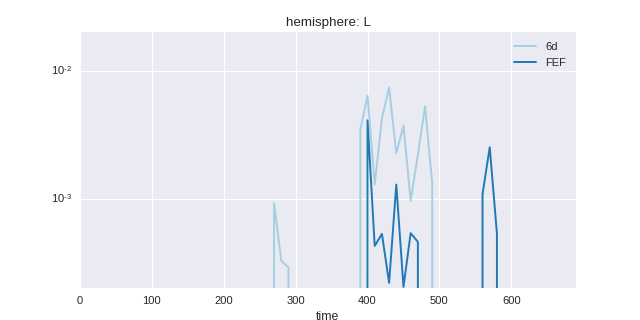

<IPython.core.display.Javascript object>


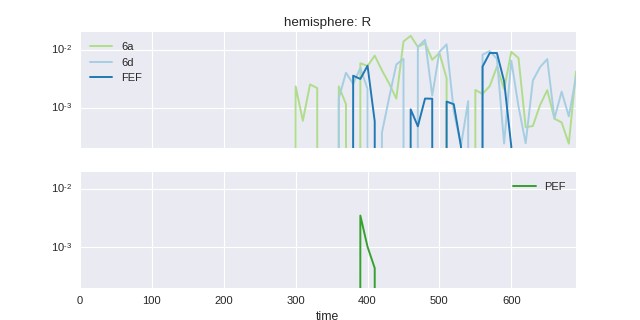

In [17]:
print(r_name)

region = 'premotor'

sv.show_timecourses(get_cluster_tcs(r_clusters[r_clusters.region.apply(lambda s: s.startswith(region))]), 
                    [threshold, ylims[measure]], logy=logy[measure])

### clusters associated with a particular area

dot_x


<IPython.core.display.Javascript object>


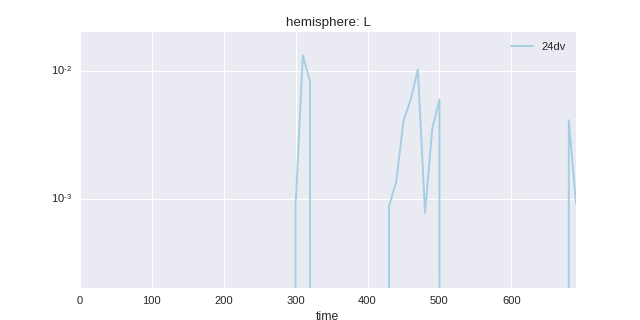

<IPython.core.display.Javascript object>


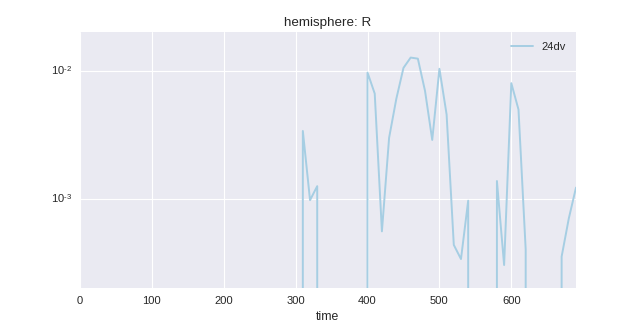

In [18]:
print(r_name)

# put the full area name in underscores such as '_1_' to match exactly
area = '_24dv_'

sv.show_timecourses(get_cluster_tcs(r_clusters[r_clusters.label.apply(lambda s: s.find(area)>0)]), 
                    [threshold, ylims[measure]], logy=logy[measure])

### clusters with reliable effect around a particular time

dot_x


<IPython.core.display.Javascript object>


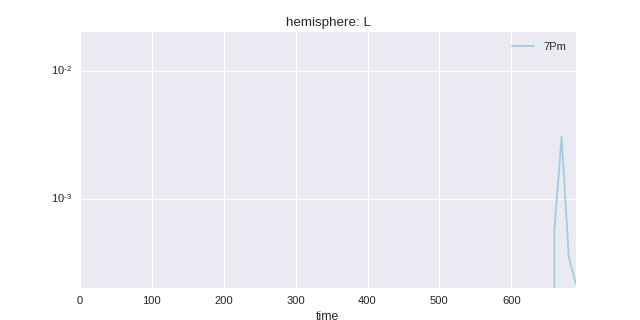

<IPython.core.display.Javascript object>


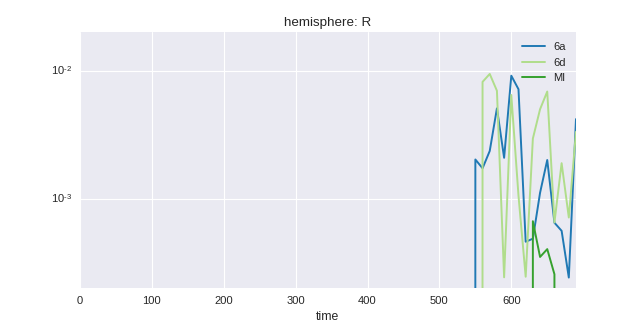

In [19]:
print(r_name)

time = 660

sv.show_timecourses(get_cluster_tcs(r_clusters[(time >= r_clusters.start_t) & (time <= r_clusters.end_t)]), 
                    [threshold, ylims[measure]], logy=logy[measure])